In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import math
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("figs", exist_ok=True)

def extract_dt(fname: str) -> float:
    # expects: filename_dt0p100.csv
    m = re.search(r"filename_dt([0-9]+p[0-9]+)\.csv$", fname)
    if not m:
        raise ValueError(f"Could not parse dt from filename: {fname}")
    dt_str = m.group(1).replace("p", ".")  # 0p100 -> 0.100
    return float(dt_str)

files = glob.glob("data/filename_dt*.csv")
if not files:
    raise FileNotFoundError("No files found matching filename_dt*.csv")

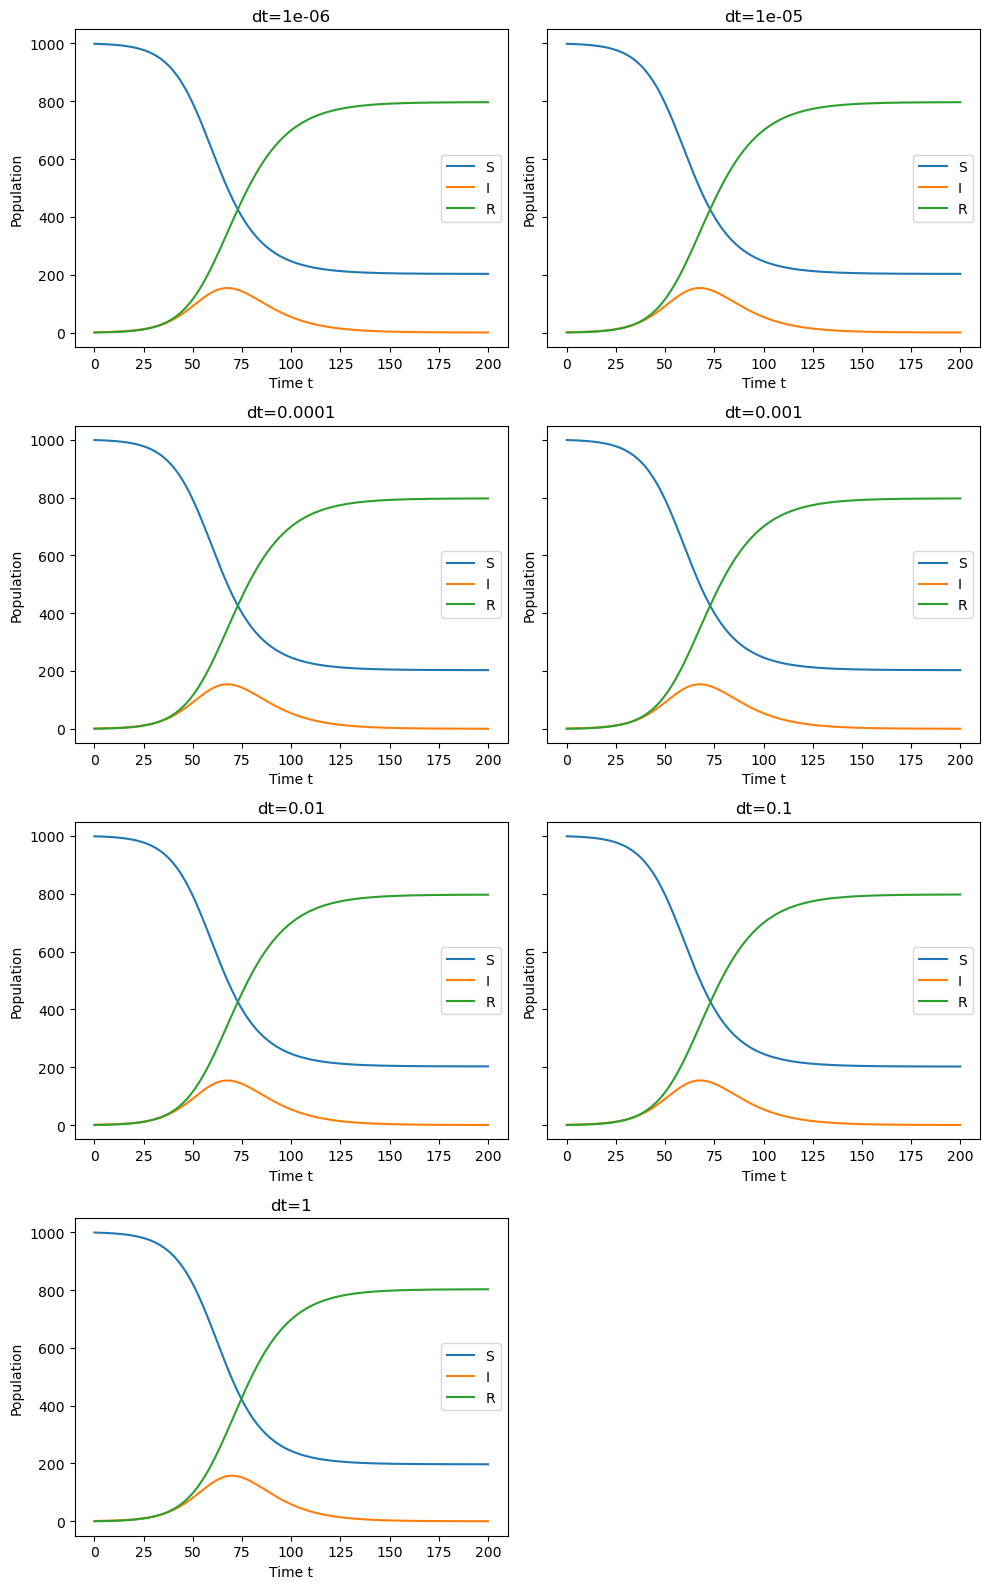

In [3]:
# sort by dt numeric
files = sorted(files, key=extract_dt)

n = len(files)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows), sharey=True)
axes = axes.flatten()

for ax, f in zip(axes, files):
    dt = extract_dt(f)
    df = pd.read_csv(f)
    df.columns = df.columns.str.strip()

    t = df["Time"]
    S = df["Susceptibile"]
    I = df["Infected"]
    R = df["Recovered"]

    ax.plot(t, S, label="S")
    ax.plot(t, I, label="I")
    ax.plot(t, R, label="R")
    ax.set_title(f"dt={dt:g}")
    ax.set_xlabel("Time t")
    ax.set_ylabel("Population")
    ax.legend()

# turn off empty panels
for ax in axes[len(files):]:
    ax.axis("off")

plt.tight_layout()
plt.savefig("figs/sir_subplots_by_dt.png", dpi=300, bbox_inches="tight")
plt.show()

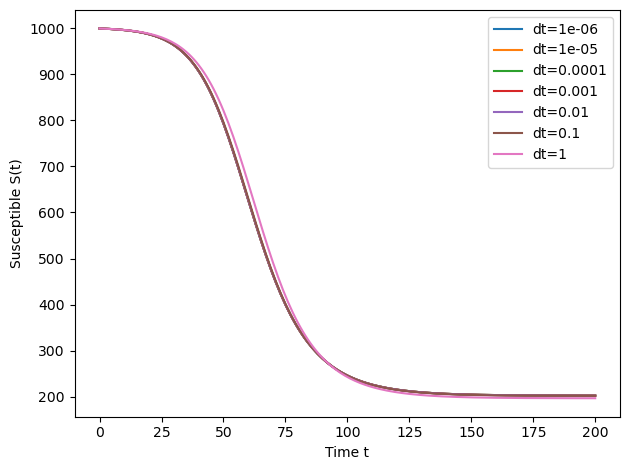

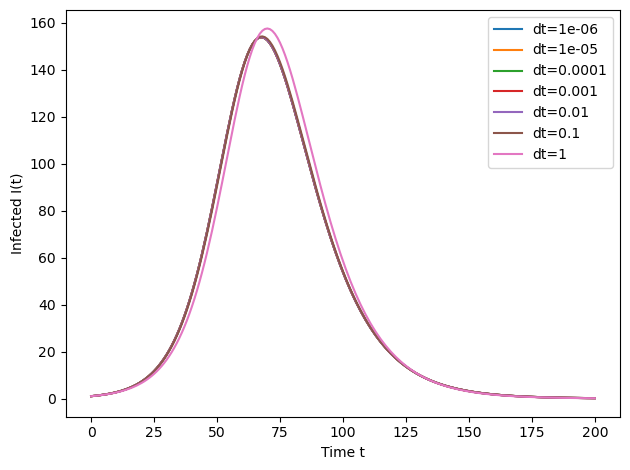

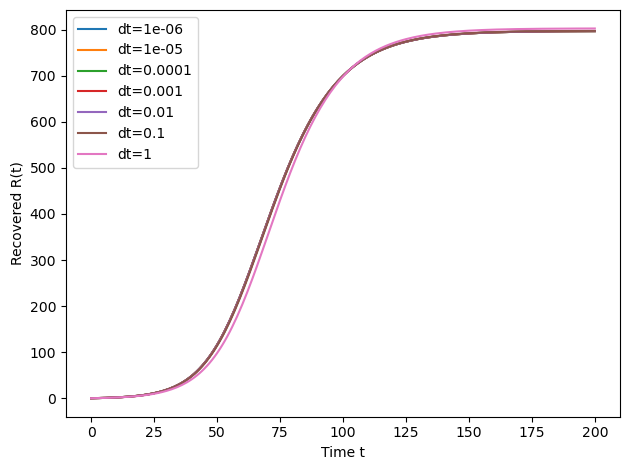

In [4]:
runs = []
for f in files:
    dt = extract_dt(f)
    df = pd.read_csv(f)
    df.columns = df.columns.str.strip()
    runs.append((dt, df))

# ---- Plot S(t) for all dt
plt.figure()
for dt, df in runs:
    plt.plot(df["Time"], df["Susceptibile"], label=f"dt={dt:g}")
plt.xlabel("Time t")
plt.ylabel("Susceptible S(t)")
plt.legend()
plt.tight_layout()
plt.savefig("figs/S_all_dt.png", dpi=300, bbox_inches="tight")
plt.show()

# ---- Plot I(t) for all dt
plt.figure()
for dt, df in runs:
    plt.plot(df["Time"], df["Infected"], label=f"dt={dt:g}")
plt.xlabel("Time t")
plt.ylabel("Infected I(t)")
plt.legend()
plt.tight_layout()
plt.savefig("figs/I_all_dt.png", dpi=300, bbox_inches="tight")
plt.show()

# ---- Plot R(t) for all dt
plt.figure()
for dt, df in runs:
    plt.plot(df["Time"], df["Recovered"], label=f"dt={dt:g}")
plt.xlabel("Time t")
plt.ylabel("Recovered R(t)")
plt.legend()
plt.tight_layout()
plt.savefig("figs/R_all_dt.png", dpi=300, bbox_inches="tight")
plt.show()


In [5]:
# reference = smallest dt
dt_ref, df_ref = runs[0]
t_ref = df_ref["Time"].to_numpy()
S_ref = df_ref["Susceptibile"].to_numpy()
I_ref = df_ref["Infected"].to_numpy()
R_ref = df_ref["Recovered"].to_numpy()

# err(dt): maximal disagreement over time and variables
dts = []
errs = []

# also store err(t) for two cases (largest dt and a small dt)
dt_large, df_large = runs[-1]
dt_small, df_small = runs[1] if len(runs) > 1 else runs[0]

def err_time_series(df, t_ref, S_ref, I_ref, R_ref):
    t = df["Time"].to_numpy()
    # validate aligned times
    if len(t) != len(t_ref) or not np.allclose(t, t_ref, rtol=0, atol=1e-12):
        raise ValueError("Time grids do not match. Check write frequency / dt divisibility.")
    S = df["Susceptibile"].to_numpy()
    I = df["Infected"].to_numpy()
    R = df["Recovered"].to_numpy()
    e_t = np.maximum.reduce([np.abs(S - S_ref), np.abs(I - I_ref), np.abs(R - R_ref)])
    return t, e_t

err_t_large = None
err_t_small = None

for dt, df in runs:
    t = df["Time"].to_numpy()
    if len(t) != len(t_ref) or not np.allclose(t, t_ref, rtol=0, atol=1e-12):
        raise ValueError(f"Time grid mismatch for dt={dt}. Fix output cadence.")
    S = df["Susceptibile"].to_numpy()
    I = df["Infected"].to_numpy()
    R = df["Recovered"].to_numpy()

    e_t = np.maximum.reduce([np.abs(S - S_ref), np.abs(I - I_ref), np.abs(R - R_ref)])
    e = np.max(e_t)

    dts.append(dt)
    errs.append(e)

    if dt == dt_large:
        err_t_large = (t, e_t)
    if dt == dt_small:
        err_t_small = (t, e_t)

dts = np.array(dts)
errs = np.array(errs)

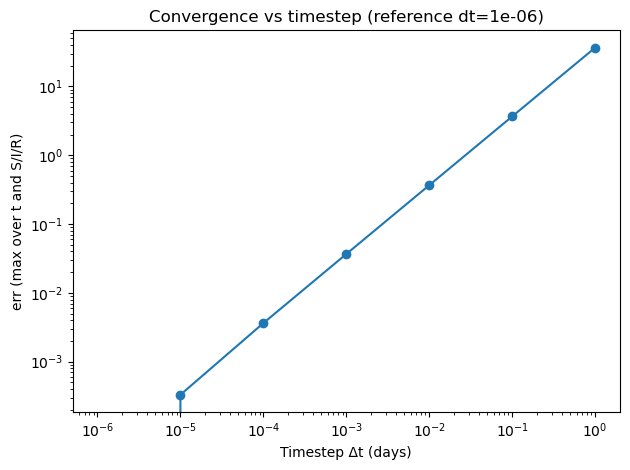

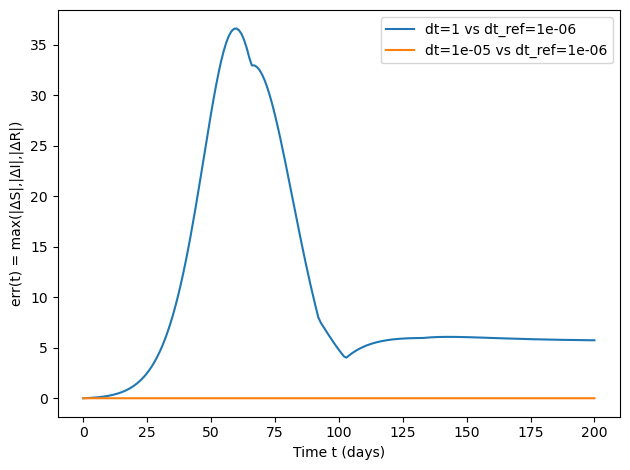

In [6]:
# Plot err vs dt
plt.figure()
plt.loglog(dts, errs, marker="o")
plt.xlabel("Timestep Δt (days)")
plt.ylabel("err (max over t and S/I/R)")
plt.title(f"Convergence vs timestep (reference dt={dt_ref:g})")
plt.tight_layout()
plt.savefig("figs/err_vs_dt.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot err(t) for large and small dt
plt.figure()
if err_t_large is not None:
    t, e_t = err_t_large
    plt.plot(t, e_t, label=f"dt={dt_large:g} vs dt_ref={dt_ref:g}")
if err_t_small is not None:
    t, e_t = err_t_small
    plt.plot(t, e_t, label=f"dt={dt_small:g} vs dt_ref={dt_ref:g}")
plt.xlabel("Time t (days)")
plt.ylabel("err(t) = max(|ΔS|,|ΔI|,|ΔR|)")
plt.legend()
plt.tight_layout()
plt.savefig("figs/err_vs_time.png", dpi=300, bbox_inches="tight")
plt.show()


In [7]:
import glob, os
print(os.getcwd())
print(glob.glob("SIR_python*.so"))

import SIR_python
print("Imported:", SIR_python)
df = pd.read_csv("Unknown_SIR_data.csv")
df.columns = df.columns.str.strip()

t_data = df["Unnamed: 0"].to_numpy()
S_data = df["S"].to_numpy()
I_data = df["I"].to_numpy()
R_data = df["R"].to_numpy()

S0 = float(S_data[0])
I0 = float(I_data[0])
R0 = float(R_data[0])
N0 = S0 + I0 + R0

t_end = float(t_data[-1])

dt_data = float(t_data[1] - t_data[0])
dt_internal = dt_data / 10.0 

/home/jovyan/erda_mount/HPPC_course/module1
['SIR_python.cpython-312-x86_64-linux-gnu.so']
Imported: <module 'SIR_python' from '/home/jovyan/erda_mount/HPPC_course/module1/SIR_python.cpython-312-x86_64-linux-gnu.so'>


In [8]:
def simulate_at_data_times(beta, gamma):
    num_steps = int(np.ceil(t_end / dt_internal))
    return_every = 1  # output every internal step

    out = SIR_python.integrate_system(S0, I0, R0, beta, gamma,
                                      dt_internal, num_steps, return_every)
    t_m = out[:, 0]
    S_m = out[:, 1]
    I_m = out[:, 2]
    R_m = out[:, 3]

    # interpolate model to the data times
    S_fit = np.interp(t_data, t_m, S_m)
    I_fit = np.interp(t_data, t_m, I_m)
    R_fit = np.interp(t_data, t_m, R_m)
    return S_fit, I_fit, R_fit

In [12]:
def loss(beta, gamma):
    S_fit, I_fit, R_fit = simulate_at_data_times(beta, gamma)

    # Reject unstable / unphysical runs (prevents overflow)
    if (not np.all(np.isfinite(S_fit)) or not np.all(np.isfinite(I_fit)) or not np.all(np.isfinite(R_fit))):
        return np.inf
    if (S_fit.min() < -1e-6) or (I_fit.min() < -1e-6) or (R_fit.min() < -1e-6):
        return np.inf
    if np.max(S_fit + I_fit + R_fit) > 2.0 * N0:   # exploded population
        return np.inf

    # normalized least squares
    S_dn = S_data / N0; I_dn = I_data / N0; R_dn = R_data / N0
    S_fn = S_fit  / N0; I_fn = I_fit  / N0; R_fn = R_fit  / N0

    err = (S_fn - S_dn)**2 + (I_fn - I_dn)**2 + (R_fn - R_dn)**2
    if not np.all(np.isfinite(err)):
        return np.inf
    return float(np.mean(err))

In [13]:
betas = np.logspace(-3, 1, 60)   # 1e-3 .. 10
gammas = np.logspace(-3, 1, 60)  # 1e-3 .. 10

best_beta, best_gamma, best_L = None, None, np.inf
for b in betas:
    for g in gammas:
        L = loss(b, g)
        if L < best_L:
            best_beta, best_gamma, best_L = b, g, L

# refine around best (factor 3 window)
betas2 = np.logspace(np.log10(best_beta/3), np.log10(best_beta*3), 60)
gammas2 = np.logspace(np.log10(best_gamma/3), np.log10(best_gamma*3), 60)

for b in betas2:
    for g in gammas2:
        L = loss(b, g)
        if L < best_L:
            best_beta, best_gamma, best_L = b, g, L

print(f"Fit results: beta={best_beta:.6g}, gamma={best_gamma:.6g}, loss={best_L:.6g}")

Fit results: beta=0.249541, gamma=0.077111, loss=0.00019481


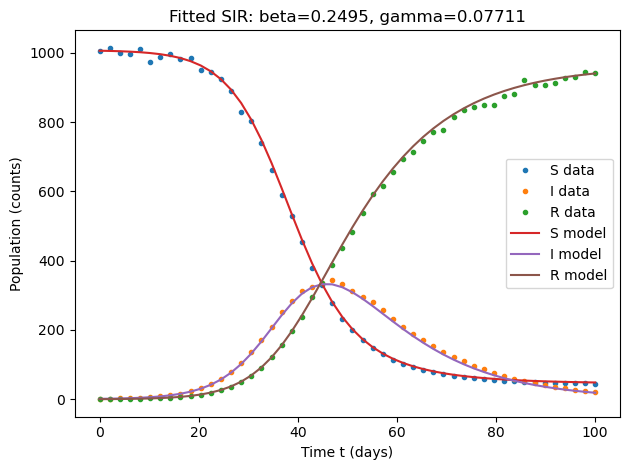

In [14]:
S_fit, I_fit, R_fit = simulate_at_data_times(best_beta, best_gamma)

os.makedirs("figs", exist_ok=True)

plt.figure()
plt.plot(t_data, S_data, "o", ms=3, label="S data")
plt.plot(t_data, I_data, "o", ms=3, label="I data")
plt.plot(t_data, R_data, "o", ms=3, label="R data")

plt.plot(t_data, S_fit, "-", label="S model")
plt.plot(t_data, I_fit, "-", label="I model")
plt.plot(t_data, R_fit, "-", label="R model")

plt.xlabel("Time t (days)")
plt.ylabel("Population (counts)")
plt.title(f"Fitted SIR: beta={best_beta:.4g}, gamma={best_gamma:.4g}")
plt.legend()
plt.tight_layout()
plt.savefig("figs/sir_fit_unknown_data.png", dpi=300, bbox_inches="tight")
plt.show()